<a href="https://colab.research.google.com/github/aryannuka/data-science/blob/main/Aryan_Unit3Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is the True Average of Erling Haaland's Expected Goals(xG) per Game?

In [2]:
!pip install "preliz[full,notebook]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 662.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.9/509.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: nbclient
    Found existing installation: nbclient 0.10.0
    Uninstalling nbclient-0.10.0:
      Successfully uninstalled nbclient-0.10.0


In [3]:
import preliz as pz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm



---

In this project, I am trying to determine the true average of Erling Haaland's expected goals per game using his stats from the 22-23 premier league season. Erling Haaland is a well known soccer(football) player that plays in Manchester City. He was the best forward in the League in the season 2022-2023 and is known for being the highest goals scored in this season with 36 goals. The game works by trying to score goals in the opposite teams goalpost by kicking the ball in. There are 11 players on the field per team at a time, making 22 players on the field total for both teams. Expected Goals in the Premier League(soccer tournament) are calculated before each game for an estimate of how many goals a certain player will score for a game. This statistic is calculated by the various types of shots the player takes, their historical statistics and how they will fair against the team that they are playing against.

---
Below is an array of Erling Haaland's expected goals(xG) for each game from the 2022 and 2023 season. In total, there are 25 points of data. This data will be used as my likelihood to create a posterior with the prior.


In [5]:
data_ppg = [
    0.86,
    0.13,
    0.46,
    1.03,
    0.46,
    0.97,
    1.23,
    1.24,
    0.59,
    1.56,
    0.18,
    0.68,
    0.55,
    0.41,
    0.24,
    0.00,
    1.58,
    1.11,
    0.10,
    0.96,
    0.26,
    1.98,
    0.04,
    0.93,
    1.73,
]

(array([5., 2., 5., 1., 4., 2., 2., 2., 1., 1.]),
 array([0.   , 0.198, 0.396, 0.594, 0.792, 0.99 , 1.188, 1.386, 1.584,
        1.782, 1.98 ]),
 <BarContainer object of 10 artists>)

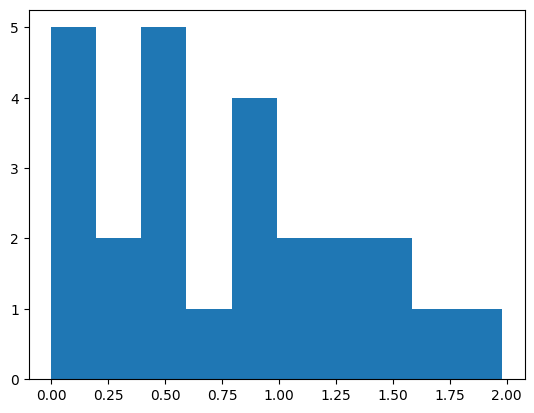

In [6]:
plt.hist(data_ppg)



---
For my prior I just used a normal distribution for the mean and half-normal for standard deviation. I chose the normal distribution for the mean since most of Haaland's expected goals per game observations will group closely around an average value as seen on the histogram and data suggests xG in majority games are between 0-1. In this instance the normal distribution is appropriate as it represents central tendency within bounds and that any true population mean must sit somewhere amid observed values, both below and above with intervals around an average.
I used a half-normal distribution for the prior on standard deviation because it is only positive. It is also skewed towards values close to zero so that the model cannot encompass very large variations in your data. This is important while modeling Haaland's xG since we expect most of the games to not have too large deviations from its mean; hence a distribution which prefers smaller values will be appropriate. This ensures that the model doesn't assume large fluctations in Haaland's goals per game, which aligns with the real world expectation of where his performance wouldn't be consistently high with the ocassional performance increase/decrease.

In [7]:
#N for normal
with pm.Model() as model_ppgN:
    #this distribution is centered at 1 with a variation of 0.7
    #as an estimate of the likelihood data
    μ = pm.Normal('μ', mu=1, sigma=0.7)

    #5 is used because of the textbook
    σ = pm.HalfNormal('σ', sigma=5)

    #creates 2 priors of mu and sigma
    Y = pm.Normal('Y', mu = μ, sigma = σ, observed=data_ppg)
    idata_ppgN = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

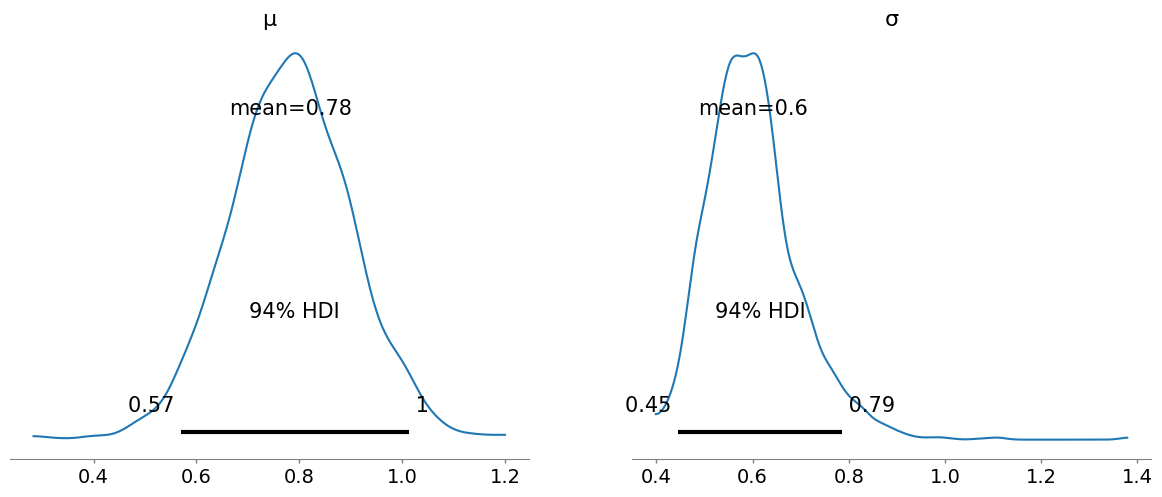

In [8]:
az.plot_posterior(idata_ppgN)

In [9]:
pm.sample_posterior_predictive(idata_ppgN, model=model_ppgN, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

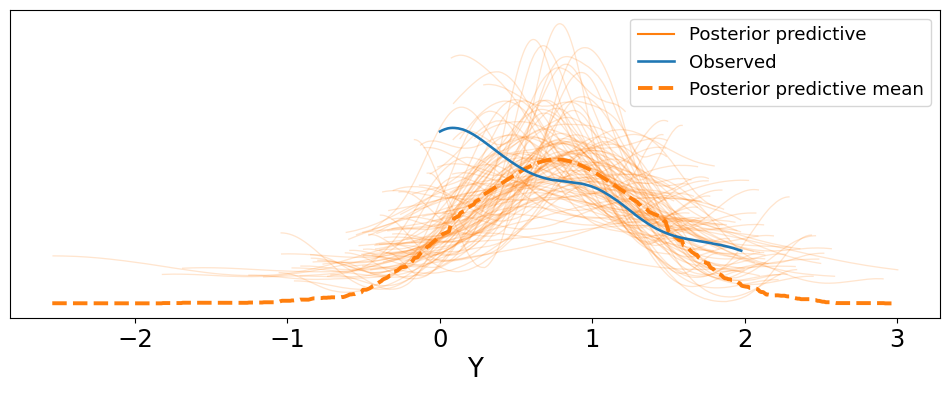

In [10]:
#This plots posterior predictive density with the smoothed version of the data overlaid

az.plot_ppc(idata_ppgN, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

This model did not end up fitting the likelihood becasue the data was much more positively skewed. The normal model used has no skew, so I instead neede to switch to a model that was able to create a postive skew. After looking through different types of distributions, I settled on the Gamma Model because it has a extreme postive skew like I needed.

This model does a poor job of fitting the likelihood because the data was more positively skewed, showing that the posterior distribution underestimates both variance and skew in Haaland's expected goals per game. To enhance the fit, it should be taken as a skewed distribution like Gamma to adjust its standard deviation prior for better reflecting how data may look.

In [11]:
#G for Gamma
with pm.Model() as model_ppgG:
    #5 is used because it's suggested by the textbook
    σ = pm.HalfNormal('σ', sigma=5)
    #this distribution is centered at 1 with a variation of 0.05 as an estimate of the likelihood data
    lam = pm.Normal('μ', mu=1, sigma=0.05)
    #creates 2 priors using exponential with lam
    Y = pm.Exponential('Y', lam = lam, observed=data_ppg)
    idata_ppgG = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

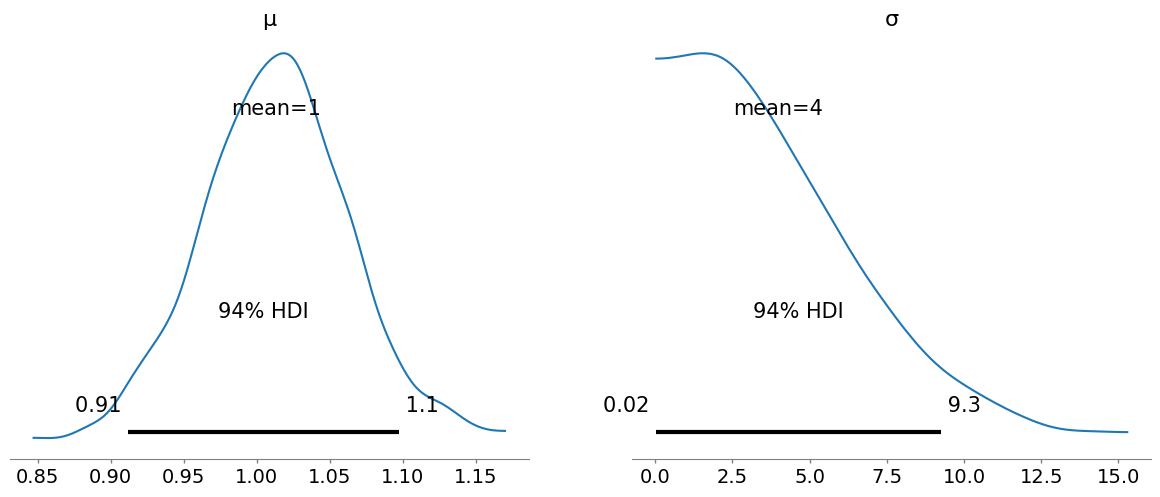

In [12]:
az.plot_posterior(idata_ppgG)

In [13]:
pm.sample_posterior_predictive(idata_ppgG, model=model_ppgG, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='Y'>

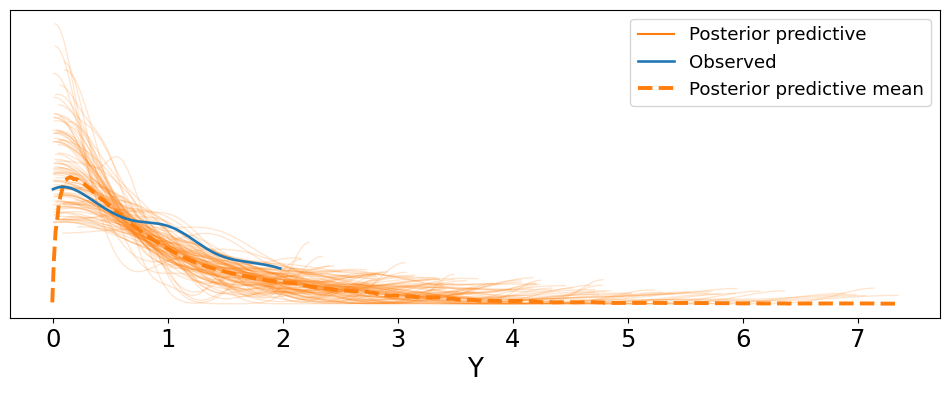

In [14]:
az.plot_ppc(idata_ppgG, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

A posterior predictive plot which represents a good fit for the data as we can see orange posterior predictive lines follow the blue line observed data. The predictions incorporate the patterns in our data, like the drop off after 1 and the long tail extending towards higher values. This fit tracks the skew in the data better, capturing those high xG outlier values well, and we see that from both the original blue line and the dashed orange posterior predictive mean that our model estimates much more realistic expectations than before.